In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [83]:
df = pd.read_csv("../../General_ds_cleaned.csv")
df = df[["date", "beta0", "beta1", "beta2", "tau", "WLbeta0", "WLbeta1", "WLbeta2", "WLtau"]]
# df = df[["date", "0.25", "0.5", "0.75", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "15.0", "20.0", "30.0"]]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", drop=True, inplace=True)
df

,beta0,beta1,beta2,tau,WLbeta0,WLbeta1,WLbeta2,WLtau
date,,,,,,,,
2003-01-04,850.031170,-299.987941,100.005078,0.000016,850.025827,-299.987158,100.004984,0.000001
2003-01-05,850.031097,-299.988336,100.004988,0.000002,850.025241,-299.987797,100.004857,0.000011
2003-01-08,850.032418,-299.987725,100.005295,0.000013,850.027882,-299.986027,100.005433,0.000001
2003-01-09,850.035191,-299.986787,100.005729,0.000015,850.028851,-299.986069,100.005713,0.000006
2003-01-10,850.030915,-299.988803,100.004964,0.000012,-99966.297012,101129.933971,-106146.270470,-4676.114939
...,...,...,...,...,...,...,...,...
2023-11-27,1178.762726,392.865962,-572.515166,0.344359,1174.659525,409.745337,-564.530459,0.325296
2023-11-28,1176.287596,349.812713,-497.037336,0.348622,1169.347673,380.911623,-483.184767,0.309327
2023-11-29,1176.081378,456.633996,-658.044054,0.306983,1137.079353,2050.755552,1110.335040,0.013144


Посмотрим на данные. Возможно лучшими моделями будут модели смешанной частоты.

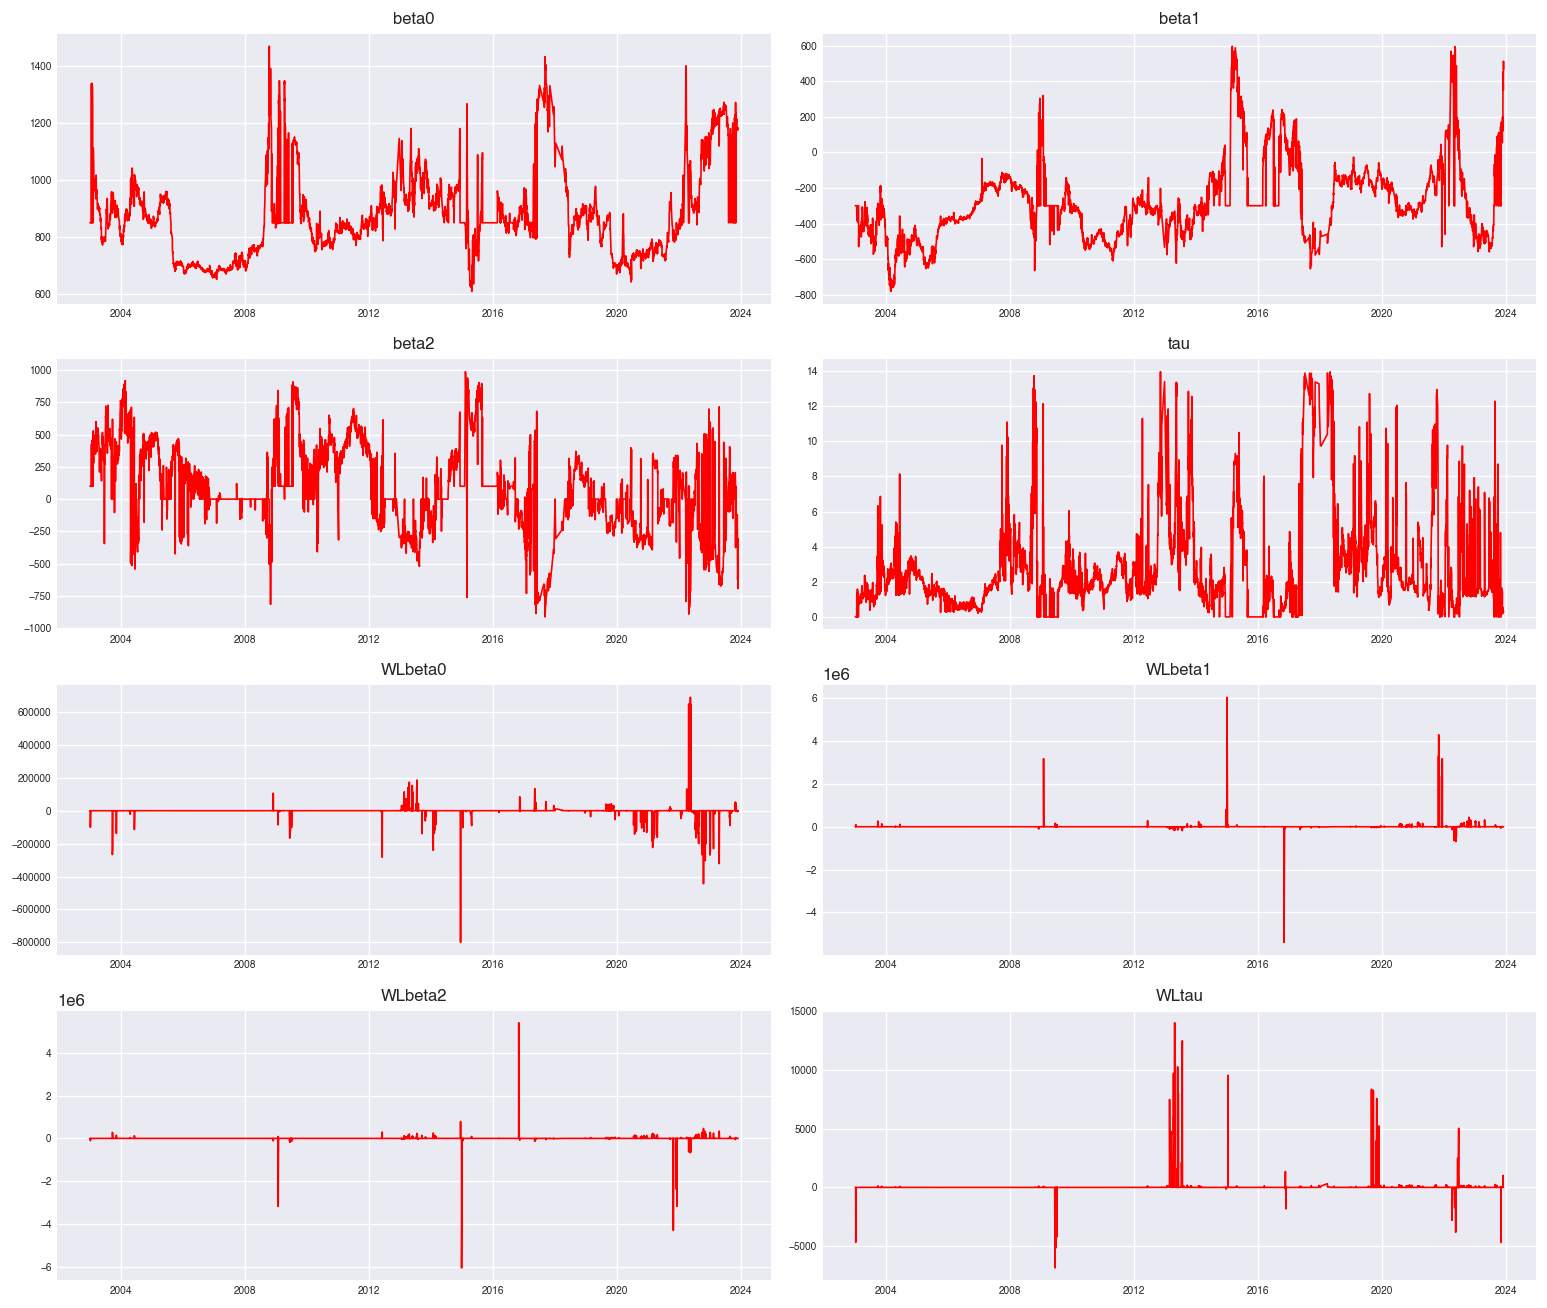

In [85]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(13,11))
for i, ax in enumerate(axes.flat):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Посмотрим тест Granger's на причинность.

In [86]:
maxlag=10

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

matrix_granger = grangers_causation_matrix(df, variables = df.columns)

Получим таблицу с p-value причинности. Получается очень хорошо, так как все друг на друга влияют. Это как раз и нужно для VAR.

In [87]:
matrix_granger[matrix_granger < 0.05]

,beta0_x,beta1_x,beta2_x,tau_x,WLbeta0_x,WLbeta1_x,WLbeta2_x,WLtau_x
beta0_y,NaN,0.0351,0.0011,0.0005,NaN,0.0000,0.0000,NaN
beta1_y,0.0280,NaN,0.0018,0.0042,0.0000,0.0018,0.0275,NaN
beta2_y,0.0119,0.0001,NaN,0.0000,0.0000,NaN,NaN,NaN
tau_y,0.0112,NaN,0.0000,NaN,0.0127,NaN,NaN,NaN
WLbeta0_y,NaN,0.0000,0.0000,0.0235,NaN,NaN,NaN,0.0004
WLbeta1_y,NaN,NaN,NaN,NaN,0.0000,NaN,0.0000,NaN
WLbeta2_y,NaN,NaN,NaN,0.0038,0.0000,0.0000,NaN,NaN
WLtau_y,NaN,NaN,0.0001,0.0011,0.0267,0.0000,0.0000,NaN


Теперь проверим на коинтеграцию, тк это является основной предпосылкой для VAR. 

In [88]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df, -1, 5)
    d = {'0.90' : 0, '0.95' : 1, '0.99' : 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
beta0  ::  2236.93   > 143.6691  =>   True
beta1  ::  1356.82   > 111.7797  =>   True
beta2  ::  850.62    > 83.9383   =>   True
tau    ::  427.43    > 60.0627   =>   True
WLbeta0 ::  148.91    > 40.1749   =>   True
WLbeta1 ::  58.39     > 24.2761   =>   True
WLbeta2 ::  17.92     > 12.3212   =>   True
WLtau  ::  0.35      > 4.1296    =>   False


Теперь приступим к разбивке на test и train(с помощью дат полученных из структурных сдвигов). Для train вычитают 5 дней от структурного сдвига, а промежуток в 5 дней беру на test.
### МЕНЯТЬ ТОЛЬКО ЗДЕСЬ!!!
1. n_horizon — количество дней, на которое предсказываем 
1. epoch — промежуток, который исследуем

In [130]:
n_horizon = 5
dates_from_struct_ms = np.array([0, 657, 1384, 3943, 4502])


time_to_fit = np.maximum((dates_from_struct_ms - n_horizon), np.zeros(len(dates_from_struct_ms))).astype(int)
time_to_predict = dates_from_struct_ms

epoch = 3
df_train, df_test = df[time_to_fit[epoch]:time_to_fit[epoch + 1]], df[time_to_fit[epoch + 1]:time_to_predict[epoch + 1]]
df_train

,beta0,beta1,beta2,tau,WLbeta0,WLbeta1,WLbeta2,WLtau
date,,,,,,,,
2019-10-10,871.472878,-238.861462,-252.555101,5.546608,873.204017,-240.770504,-251.512356,5.666143
2019-10-11,871.401875,-236.827888,-250.549455,5.949593,652.884230,-558.494470,97.623450,0.015344
2019-10-14,880.116830,-248.834162,-246.235740,6.604045,19114.502493,-18484.550109,-17928.329850,110.502291
2019-10-15,826.110447,-193.436764,-212.103603,5.188040,781.294047,-146.629564,-187.067612,3.676640
2019-10-16,829.433273,-200.437511,-181.145054,6.040058,804.114485,-174.135828,-174.679852,4.822609
...,...,...,...,...,...,...,...,...
2022-02-07,850.666836,118.516641,57.097672,9.022855,893.216981,76.555658,-0.085653,9.150589
2022-02-08,877.445271,95.516239,-0.013026,9.773161,911.276298,62.640738,0.005632,5.155008
2022-02-09,890.734984,85.758156,-0.000021,6.883329,903.505848,73.428108,-0.000059,5.389945


Проверим на стационарность.

In [131]:
def adjust(val, length= 6): return str(val).ljust(length)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [132]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "beta0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4843
 No. Lags Chosen       = 0
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.1193. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "beta1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8242
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.992. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "beta2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

Получили, что не все стационарны. Возьмем разницу и снова проверим.

In [133]:
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "beta0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.1577
 No. Lags Chosen       = 0
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7822
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [134]:
max_parametrs_for_var = 10
model = VAR(df_differenced)
for i in np.arange(1,max_parametrs_for_var):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  91.98611852904713
BIC :  92.54487022971996
FPE :  8.893515402125131e+39
HQIC:  92.20434833626588 

Lag Order = 2
AIC :  91.85620566154653
BIC :  92.91308423711861
FPE :  7.811051330178566e+39
HQIC:  92.26901984938469 

Lag Order = 3
AIC :  91.73333555042731
BIC :  93.28972045628188
FPE :  6.910244211410386e+39
HQIC:  92.3413037822737 

Lag Order = 4
AIC :  91.7107850706812
BIC :  93.76806210552105
FPE :  6.76049475815922e+39
HQIC:  92.51447968166724 

Lag Order = 5
AIC :  91.67626257304576
BIC :  94.23582391933749
FPE :  6.537956923663052e+39
HQIC:  92.67625858719718 

Lag Order = 6
AIC :  91.79980450915147
BIC :  94.86304877389897
FPE :  7.409286477193899e+39
HQIC:  92.99667965667963 

Lag Order = 7
AIC :  91.86196568094122
BIC :  95.4302979367919
FPE :  7.901791916348033e+39
HQIC:  93.25630041567544 

Lag Order = 8
AIC :  91.94153315581137
BIC :  96.01636498249826
FPE :  8.581360377489632e+39
HQIC:  93.5339106727736 

Lag Order = 9
AIC :  92.02805078630253
BIC : 

Получили, что лучший параметр $p = 9$.

In [135]:
p = 9
model_fitted = model.fit(p)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Dec, 2023
Time:                     21:59:05
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    96.6108
Nobs:                     549.000    HQIC:                   93.8191
Log likelihood:          -30909.7    FPE:                9.39244e+39
AIC:                      92.0281    Det(Omega_mle):     3.45967e+39
--------------------------------------------------------------------
Results for equation beta0
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.147829         0.536339            0.276           0.783
L1.beta0           0.022514         0.052913            0.426           0.670
L1.beta1           0.048214         0.019255            2.504           

Изучим статистику Durbina для проверки корреляций между остатками. Иначе если в остатках есть корреляция, то во временном ряду есть закономерность, которую нужну объяснить.

In [136]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

beta0  : 2.0
beta1  : 2.0
beta2  : 1.97
tau    : 2.0
WLbeta0 : 2.0
WLbeta1 : 2.06
WLbeta2 : 2.06
WLtau  : 1.87


Остатки выглядят очень хорошо(очень близко к 2). Теперь осталось рассмотреть предсказания. Учтем также то, что лучше всего брать промежуток для форкаста равный количестве лагов. В нашем же случае все совпало и мы точно разделили выборку.

In [137]:
var_model_forecast = model_fitted.forecast(y = df_differenced.values, steps=n_horizon)
df_forecast = pd.DataFrame(var_model_forecast, index = df_test.index, columns = df.columns + '_1d' )
df_forecast

,beta0_1d,beta1_1d,beta2_1d,tau_1d,WLbeta0_1d,WLbeta1_1d,WLbeta2_1d,WLtau_1d
date,,,,,,,,
2022-02-14,-7.969016,9.149540,25.685690,0.112211,-2466.592798,415019.998692,-412059.894095,-73.791144
2022-02-15,-2.756415,-31.055988,-18.438985,-0.453650,3850.481163,-225096.213246,216542.271601,-83.249465
2022-02-16,3.983013,6.361250,-17.924649,-0.562985,1855.748117,428533.950247,-430885.905887,142.276914
2022-02-17,-8.366036,2.031101,38.507658,0.658748,2690.252361,-391955.844088,382728.472053,-308.673371
2022-02-18,2.457604,-20.512449,-16.560809,-0.020389,-7598.124190,-101482.884921,120837.559929,292.216966


In [138]:
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [139]:
df_results = invert_transformation(df_train, df_forecast)
df_results

,beta0_1d,beta1_1d,beta2_1d,tau_1d,WLbeta0_1d,WLbeta1_1d,WLbeta2_1d,WLtau_1d,beta0_forecast,beta1_forecast,beta2_forecast,tau_forecast,WLbeta0_forecast,WLbeta1_forecast,WLbeta2_forecast,WLtau_forecast
date,,,,,,,,,,,,,,,,
2022-02-14,-7.969016,9.149540,25.685690,0.112211,-2466.592798,415019.998692,-412059.894095,-73.791144,908.685174,105.077893,131.025396,3.370273,-1563.195769,415129.337093,-411943.246754,-70.098614
2022-02-15,-2.756415,-31.055988,-18.438985,-0.453650,3850.481163,-225096.213246,216542.271601,-83.249465,905.928759,74.021905,112.586411,2.916623,2287.285395,190033.123847,-195400.975153,-153.348079
2022-02-16,3.983013,6.361250,-17.924649,-0.562985,1855.748117,428533.950247,-430885.905887,142.276914,909.911772,80.383155,94.661763,2.353637,4143.033512,618567.074094,-626286.881040,-11.071165
2022-02-17,-8.366036,2.031101,38.507658,0.658748,2690.252361,-391955.844088,382728.472053,-308.673371,901.545736,82.414255,133.169421,3.012385,6833.285873,226611.230006,-243558.408987,-319.744536
2022-02-18,2.457604,-20.512449,-16.560809,-0.020389,-7598.124190,-101482.884921,120837.559929,292.216966,904.003340,61.901806,116.608612,2.991996,-764.838318,125128.345084,-122720.849058,-27.527570


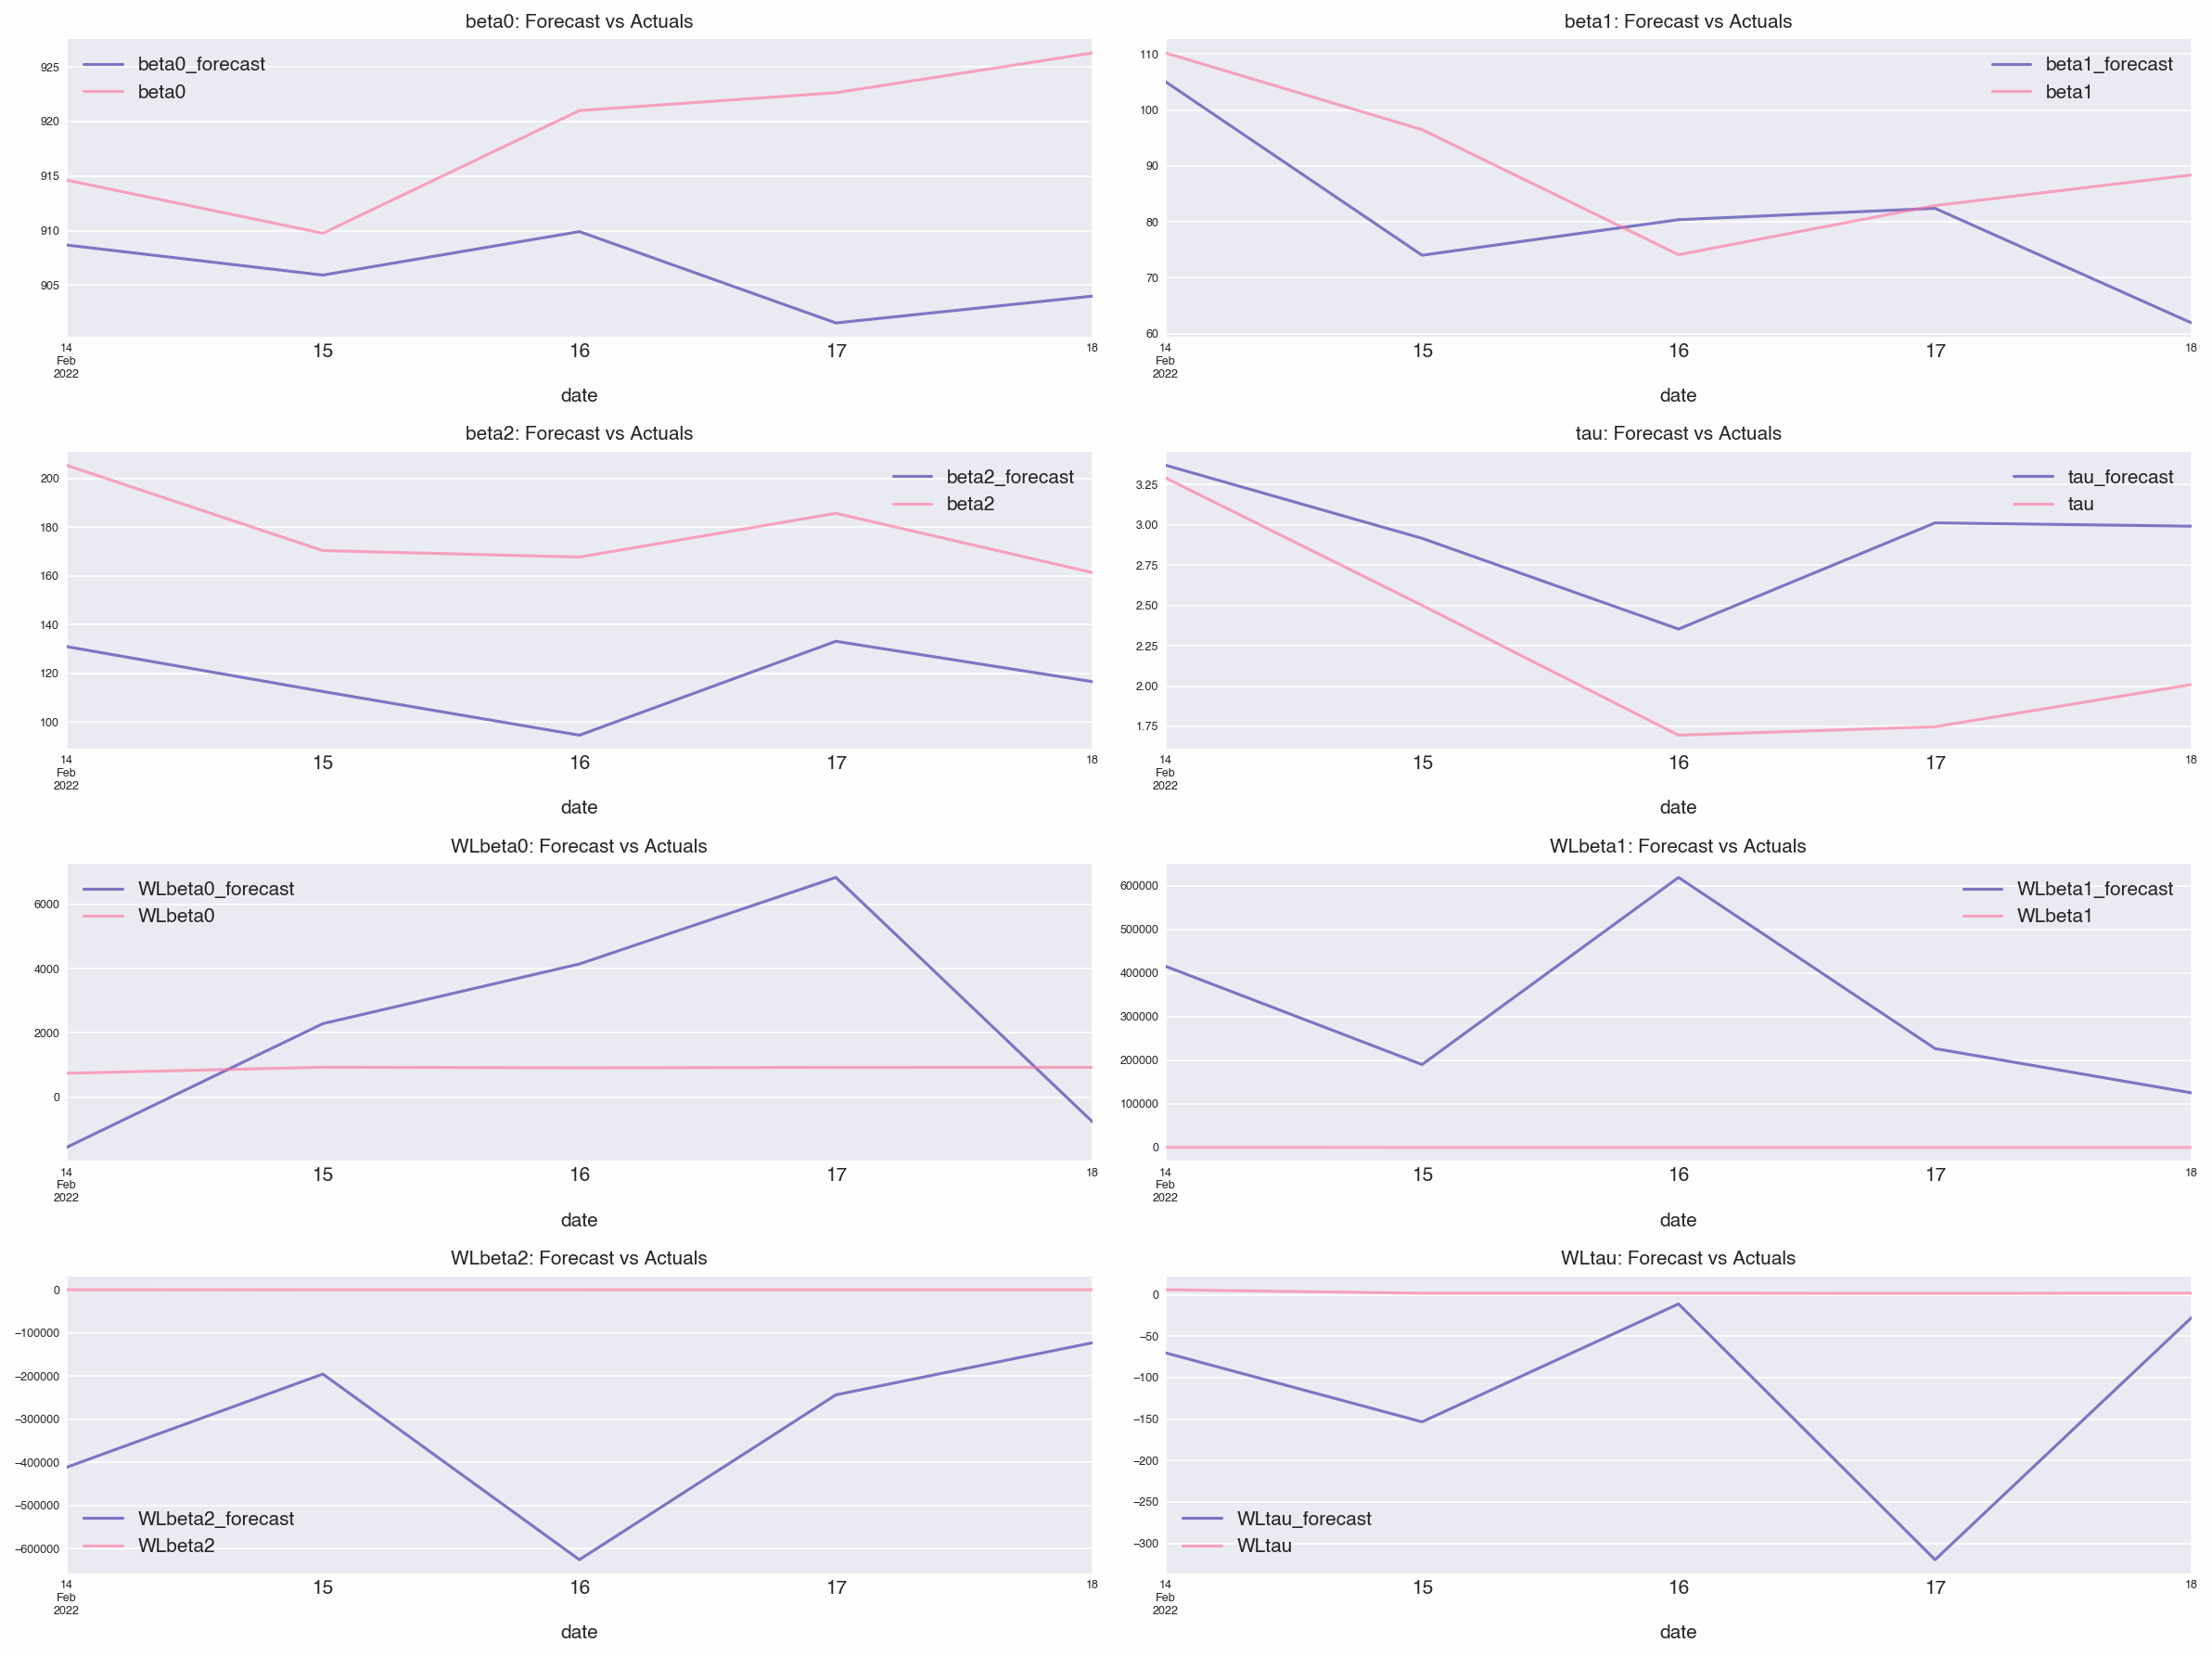

In [140]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(16, 12))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals", fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [141]:
df_results

,beta0_1d,beta1_1d,beta2_1d,tau_1d,WLbeta0_1d,WLbeta1_1d,WLbeta2_1d,WLtau_1d,beta0_forecast,beta1_forecast,beta2_forecast,tau_forecast,WLbeta0_forecast,WLbeta1_forecast,WLbeta2_forecast,WLtau_forecast
date,,,,,,,,,,,,,,,,
2022-02-14,-7.969016,9.149540,25.685690,0.112211,-2466.592798,415019.998692,-412059.894095,-73.791144,908.685174,105.077893,131.025396,3.370273,-1563.195769,415129.337093,-411943.246754,-70.098614
2022-02-15,-2.756415,-31.055988,-18.438985,-0.453650,3850.481163,-225096.213246,216542.271601,-83.249465,905.928759,74.021905,112.586411,2.916623,2287.285395,190033.123847,-195400.975153,-153.348079
2022-02-16,3.983013,6.361250,-17.924649,-0.562985,1855.748117,428533.950247,-430885.905887,142.276914,909.911772,80.383155,94.661763,2.353637,4143.033512,618567.074094,-626286.881040,-11.071165
2022-02-17,-8.366036,2.031101,38.507658,0.658748,2690.252361,-391955.844088,382728.472053,-308.673371,901.545736,82.414255,133.169421,3.012385,6833.285873,226611.230006,-243558.408987,-319.744536
2022-02-18,2.457604,-20.512449,-16.560809,-0.020389,-7598.124190,-101482.884921,120837.559929,292.216966,904.003340,61.901806,116.608612,2.991996,-764.838318,125128.345084,-122720.849058,-27.527570


In [142]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)    
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [143]:
for col_name in df.columns:
    print('Forecast Accuracy of: ' + col_name)
    accuracy_prod = forecast_accuracy(df_results[col_name + '_forecast'].values, df_test[col_name])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: beta0
mape   :  0.0139
me     :  -12.8457
mae    :  12.8457
mpe    :  -0.0139
rmse   :  14.9255
Forecast Accuracy of: beta1
mape   :  0.134
me     :  -9.6703
mae    :  12.1766
mpe    :  -0.1002
rmse   :  15.9566
Forecast Accuracy of: beta2
mape   :  0.3394
me     :  -60.4861
mae    :  60.4861
mpe    :  -0.3394
rmse   :  61.5831
Forecast Accuracy of: tau
mape   :  0.3582
me     :  0.68
mae    :  0.68
mpe    :  0.3582
rmse   :  0.7972
Forecast Accuracy of: WLbeta0
mape   :  3.258
me     :  1298.3181
mae    :  2897.9639
mpe    :  1.2866
rmse   :  3326.761
Forecast Accuracy of: WLbeta1
mape   :  3185.5064
me     :  314973.4401
mae    :  314973.4401
mpe    :  3185.5064
rmse   :  362672.6109
Forecast Accuracy of: WLbeta2
mape   :  1599.7298
me     :  -320196.2093
mae    :  320196.2093
mpe    :  -1599.7298
rmse   :  367486.4973
Forecast Accuracy of: WLtau
mape   :  62.4744
me     :  -119.0502
mae    :  119.0502
mpe    :  -62.4744
rmse   :  163.8478
